In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Create a sampling layer


In [20]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



## Build the encoder


In [21]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

## Build the decoder


In [22]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Define the VAE as a `Model` with a custom `train_step`


In [23]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            #print(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }



## Train the VAE


In [24]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=100, batch_size=128)


Epoch 1/100
547/547 [==============================] - 4s 7ms/step - loss: 209.6951 - reconstruction_loss: 207.4358 - kl_loss: 2.2593
Epoch 2/100
547/547 [==============================] - 4s 7ms/step - loss: 181.6592 - reconstruction_loss: 178.4512 - kl_loss: 3.2080
Epoch 3/100
547/547 [==============================] - 4s 7ms/step - loss: 165.5974 - reconstruction_loss: 161.8303 - kl_loss: 3.7671
Epoch 4/100
547/547 [==============================] - 4s 7ms/step - loss: 160.7977 - reconstruction_loss: 157.0331 - kl_loss: 3.7646
Epoch 5/100
547/547 [==============================] - 4s 7ms/step - loss: 158.0508 - reconstruction_loss: 154.2832 - kl_loss: 3.7676
Epoch 6/100
547/547 [==============================] - 4s 7ms/step - loss: 156.2061 - reconstruction_loss: 152.4223 - kl_loss: 3.7838
Epoch 7/100
547/547 [==============================] - 4s 6ms/step - loss: 154.7864 - reconstruction_loss: 150.9905 - kl_loss: 3.7959
Epoch 8/100
547/547 [==============================] - 4s 7ms/

## Plot the Gaussian distributions that you have obtained at the latent space

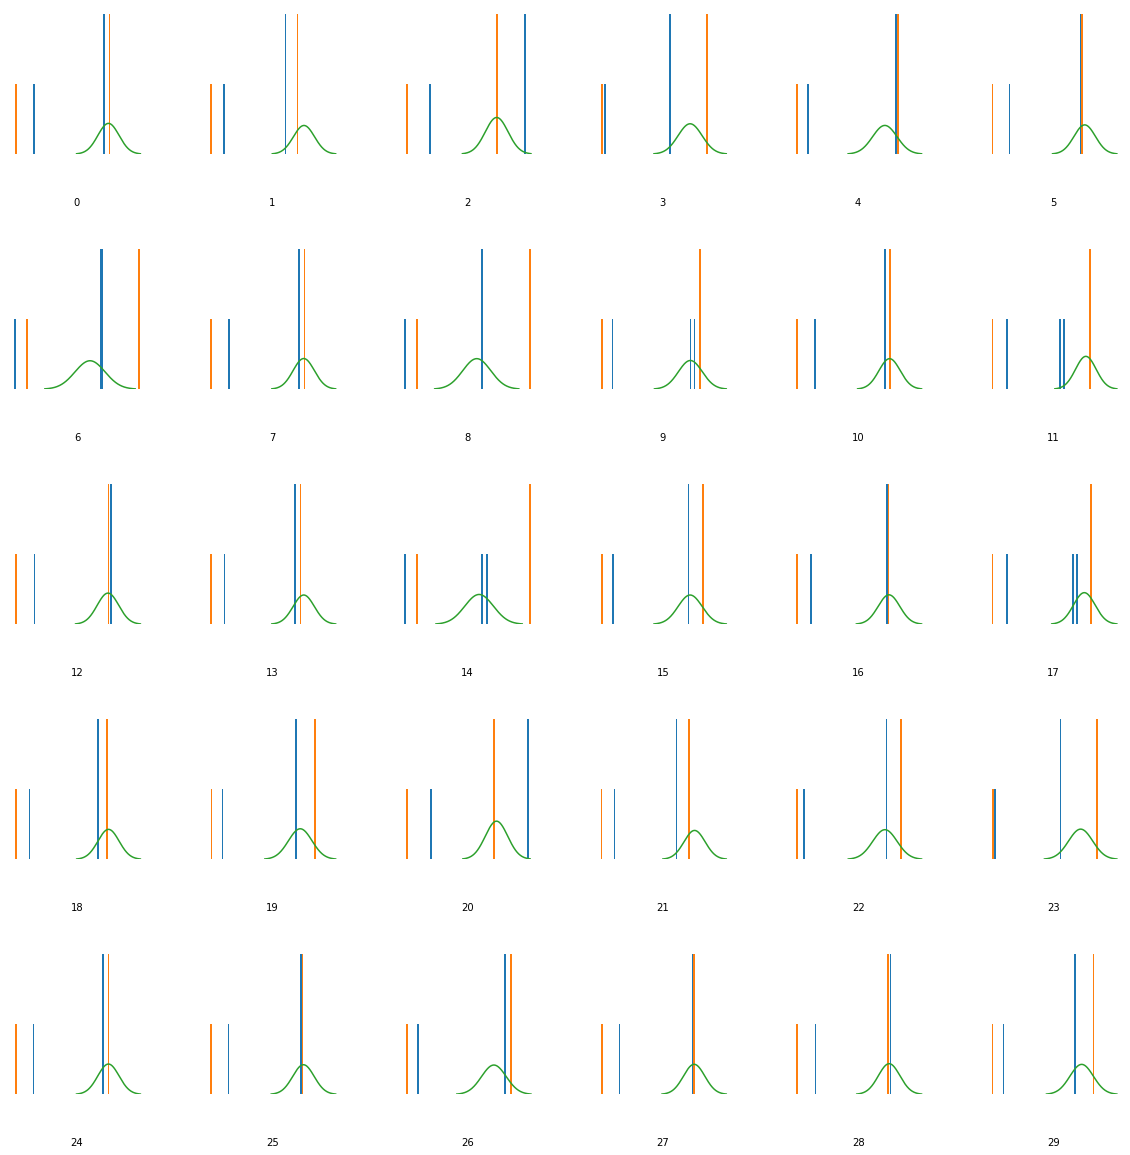

In [25]:
from scipy.stats import norm

z_test = encoder.predict(mnist_digits[:30])
z_test = np.array(z_test)
x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(30):
    ax = fig.add_subplot(5, 6, i+1)
    ax.hist(z_test[:, i], density=True, bins = 25)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

## (b) Identify what each latent variable is controlling
### Display a grid of sampled digits

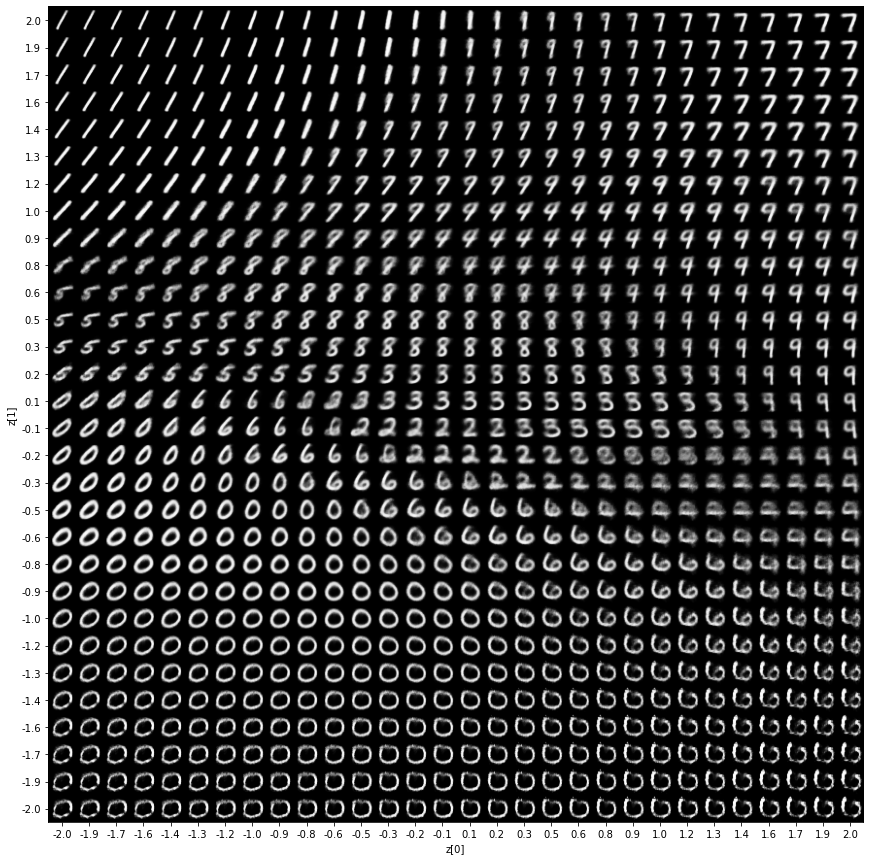

In [26]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


A great way to have a more visual understanding of the latent space continuity is to look at generated images from a latent space area. <br>
From the above of latent space of generated images, we can observe that latent speaces(Z[0], Z[1]) <br>
Z[0] from -2 to -0.5 and Z[1] from -2.0 to -0.5 Controlling the properties of 0  and <br>
Z[1] from 1.3 to 2.0 and Z[0] from -2.0 to -0.6 Controlling the properties of 1 <br>
Z[0] from 1.3 to 2.0 and Z[1] from 1.3 to 2.0 Controlling the properties of 7 <br>
and same for other digits like spectific region of z[0] and z[1] is Controlling specific digit <br>
**We can see in the figure that digits are smoothly converted so similar one when moving throughout the latent space like 3 and 8 is closer and 7 and 1 are closer**

#### One interesting thing about VAEs is that the latent space learned during training has some nice continuity properties. We can visualise these properties by considering a 2 dimensional latent space in order to be able to visualise our data points easily in 2D

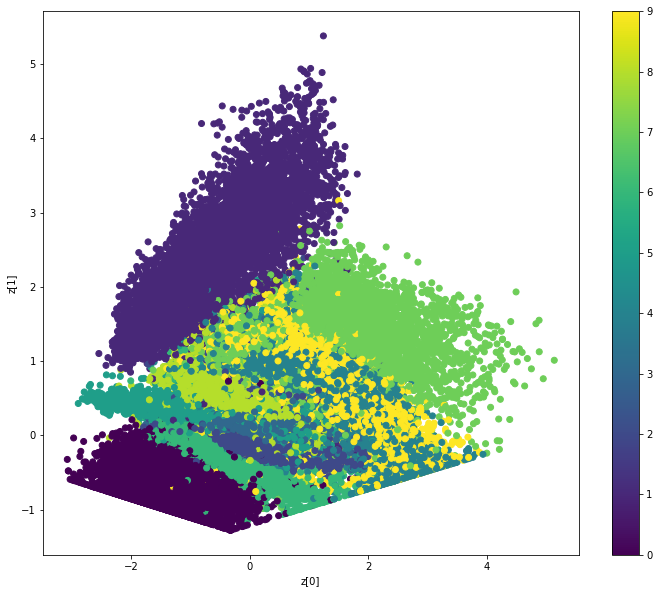

In [27]:

def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c = labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)


#### When looking at the repartition of the MNIST dataset samples in the 2D latent space learned during training, we can see that similar digits are grouped together (all 3's are all grouped together and close to 8 that are quite similar).

In [29]:
##Code Credits : Most of the code is from Keras VAE tutorial and made some changes on it 
## and some concepts from https://towardsdatascience.com/an-introduction-to-variational-auto-encoders-vaes-803ddfb623df
## and https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8